# BSP-inspired bitsets: 46% smaller than Roaring (but probably not faster)

> **Scope:** Pre-engineering research measuring compression only. Performance estimated.
> **Created by [Ashton Six](https://ashtonsix.com)** (available for hire).

---

Bitset performance is typically memory-bound: once main-memory saturates (~6 GB/s) extra compute won’t accelerate AND/OR/XOR. This motivates _operational compression_: keeping sets compressed in memory to stream more values through compute while retaining set algebra speed.

We compare Roaring and Judy against Binary Space Partitioning (BSP)-style encoders and two-stage hybrids. **This work measures compression ratios only**—we estimate throughput characteristics through system modeling, but do not implement or benchmark actual codecs.

**Findings (short):**

* **BSP dominates compression.** **Left-popcount (LP)** and **median-index (MI)** yield bitsets \~**46% smaller** than the best non-BSP baseline (Roaring+RLE) on aggregate.
* **Hybrid policies don’t help compression.** Mixing LP+MI and/or adding preprocessing passes doesn't pay off; control overhead erases gains and adds complexity.
* **Entropy concentrates in the low 8-12 bits.** Two-stage designs can maintain single-stage compression ratios while improving codec practicality.

**Outcome:** We identify a promising two-stage architecture:

  * **Stage 1 (high bits):** Performance-oriented indexing (Judy16 or similar)
  * **Stage 2 (low 8-12 bits):** Compression-oriented encoding (LP, MI, or micro-containers)

LP/MI offer the best compression; simpler micro-containers (e.g., pickbest) sacrifice ~20% compression but should prove easier to accelerate.

---

# Preamble

This notebook distills results from an experimental C++ workbench (`bspx_*.cpp`). Each experiment composes transforms (restructure data and/or add sidechains) with a terminal policy (bit-count model). Pipelines run per dataset; results are aggregated to CSV and analysed here.

**Workbench layout**

* `bspx_main.cpp` — declares pipelines, runs in parallel, writes `report.csv`.
* `bspx_policy.hpp` — policies (LP, MI, …), transforms (cluster, RLE, …), helpers.
* `bspx_runtime.hpp` — data loader, pipeline executor, CSV/report utilities.
* `bspx_telemetry.hpp` — metrics emitted by transforms/policies.

**Running**

```sh
make -f bspx.mk && ./out/bspx
```

**Datasets**

* CRoaring “realdata” (`census-income`, `census1881`, `uscensus2000`, `weather_sept_85`, `wikileaks-noquotes`).
* Contains 1800 files, each with a sorted `uint32_t` set.
* Some files are exact duplicates, we evaluate the 1570 unique sets.

In [1]:
# Imports, constants
from pathlib import Path
import bspx_analysis_helpers as bspx
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from IPython.display import display

PROJECT_ROOT = Path.cwd()
REPORT_PATH = PROJECT_ROOT / "report.csv"

In [2]:
# Load & parse report.csv

# Parses 'k=v|k=v|...' metric columns, drops hash-equal bitsets, and computes derived columns:
#   file->dataset/bitset
#   P{span_i}.<metric> -> P{total/avg}.<metric> (stats probe)
df = bspx.load_report(REPORT_PATH)

print(
    f"Loaded {len(df):,} rows x {len(df.columns):,} columns across {df['file'].nunique():,} datasets and {df['policy'].nunique():,} policies."
)
print("Policies:", df["policy"].unique())
print("Columns:", list(df.columns))

bitsets_per_dataset = df.groupby("dataset")["bitset"].nunique()
print("Unique bitsets per dataset:")
print(bitsets_per_dataset)

df

Loaded 47,100 rows x 124 columns across 1,570 datasets and 30 policies.
Policies: ['roaring-B+A' 'roaring-B+A+R' 'leftpop' 'median-index' 'tagged-bisect'
 'bsp-mixed' 'leftpop-then@N4-enum' 'leftpop-then@N1-array'
 'leftpop-then@S8-bitset' 'leftpop-scalar-fixed' 'leftpop-scalar-uniform'
 'cluster-then-leftpop' 'cluster-then-median' 'rle-then-leftpop'
 'rle-then-median' 'judy256' 'judy16' 'judy4' 'judy2'
 'judy16-then@D8-leftpop' 'judy16-then@D12-leftpop'
 'judy16-then@D16-leftpop' 'judy16-then@D8-median-index'
 'judy16-then@D12-median-index' 'judy16-then@D16-median-index'
 'judyX-then@D8-leftpop' 'judyX-then@D12-leftpop'
 'judy16-then@D8-pickbest' 'judy4-then@D8-drop-full'
 'shannon-uniform-best']
Columns: ['file', 'dataset', 'bitset', 'n', 'policy', 'bits', 'BSP_decision_cost_bits', 'BSP_es_nodes', 'BSP_lp_nodes', 'BSP_mi_nodes', 'LCC_term_bal', 'LCC_term_cl', 'LCC_term_co', 'LRRC_len_max', 'LRRC_len_min', 'LRRC_len_total', 'LRRC_regions', 'LRRC_runs', 'L_NARROW_Unew', 'L_XFORM_bits',

,file,dataset,bitset,n,policy,bits,BSP_decision_cost_bits,BSP_es_nodes,BSP_lp_nodes,BSP_mi_nodes,...,PROBE_boxes[4],PROBE_avg_density[4],PROBE_avg_runs[4],PROBE_imbalance_kl[4],PROBE_lp_bits[4],PROBE_lp_center[4],PROBE_lp_log2K[4],PROBE_mi_bits[4],PROBE_mi_center[4],PROBE_mi_log2K[4]
0,../.common/data-bitset/census-income/census-in...,census-income,0,101212,roaring-B+A,219712.000000,0.0,0.0,0.0,0.0,...,1.0,0.0,49925.0,1.0,16.705,0.5,16.627,28.0,0.500,27.999
1,../.common/data-bitset/census-income/census-in...,census-income,0,101212,roaring-B+A+R,219552.000000,0.0,0.0,0.0,0.0,...,1.0,0.0,49925.0,1.0,16.705,0.5,16.627,28.0,0.500,27.999
2,../.common/data-bitset/census-income/census-in...,census-income,0,101212,leftpop,252332.912550,0.0,0.0,273477.0,0.0,...,1.0,0.0,49925.0,1.0,16.705,0.5,16.627,28.0,0.500,27.999
3,../.common/data-bitset/census-income/census-in...,census-income,0,101212,median-index,223867.947565,0.0,0.0,0.0,101212.0,...,1.0,0.0,49925.0,1.0,16.705,0.5,16.627,28.0,0.500,27.999
4,../.common/data-bitset/census-income/census-in...,census-income,0,101212,tagged-bisect,212040.361681,0.0,0.0,0.0,0.0,...,1.0,0.0,49925.0,1.0,16.705,0.5,16.627,28.0,0.500,27.999
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
53995,../.common/data-bitset/wikileaks-noquotes_srt/...,wikileaks-noquotes_srt,199,3835,judyX-then@D8-leftpop,222.970390,0.0,0.0,0.0,0.0,...,1.0,0.0,1.0,1.0,11.932,0.5,11.905,28.0,0.496,28.000
53996,../.common/data-bitset/wikileaks-noquotes_srt/...,wikileaks-noquotes_srt,199,3835,judyX-then@D12-leftpop,250.868484,0.0,0.0,0.0,0.0,...,1.0,0.0,1.0,1.0,11.932,0.5,11.905,28.0,0.496,28.000
53997,../.common/data-bitset/wikileaks-noquotes_srt/...,wikileaks-noquotes_srt,199,3835,judy16-then@D8-pickbest,773.060606,0.0,0.0,0.0,0.0,...,1.0,0.0,1.0,1.0,11.932,0.5,11.905,28.0,0.496,28.000
53998,../.common/data-bitset/wikileaks-noquotes_srt/...,wikileaks-noquotes_srt,199,3835,judy4-then@D8-drop-full,708.060606,0.0,0.0,0.0,0.0,...,1.0,0.0,1.0,1.0,11.932,0.5,11.905,28.0,0.496,28.000


# Background

## Motivation

Search, OLAP, and stream analytics rely on compressed bitsets for fast filtering, joins, set algebra, and counts with minimal memory traffic. Roaring-style implementations dominate (Lucene, Spark, Kylin, Druid, ClickHouse, …).

## Prior Art

* **Judy (~2001–2004).** High-fanout radix arrays; influential but pointer-heavy.
* **RLE family (WAH→PLWAH/CONCISE/EWAH, ~2004–2010).** Word-aligned run-length encoders; historically important, superseded by Roaring.
* **Roaring (2014) → run containers (2016).** Two-level partitioning (high-16-bit) with per-container encoding (array/bitmap). Initial results showed Roaring as **4–5× faster** than WAH for intersections; later **run containers** yielded consistently smaller bitmaps than RLE-only schemes.
* **BSP / quasi-succinct (BIC/PEF, 2000s–2010s).** State-of-the-art compression for bitsets via recursive bisection. Dominate research-grade inverted indices (PISA); rarely used for industry DB engines due to engineering pitfalls.

## Our contribution

We revive Judy’s high-bit partitioning and apply BSP-inspired coding to the low bits within each partition.

---

# Method and Results: single-stage policies at a glance

All BSP policies descend by recursive bisection from the universe:

* **Left-popcount (LP):** split at midpoint; encode the left-side popcount under a feasible alphabet; recurse.
* **Median-index (MI):** encode a feasible median position; recurse strictly left/right.
* **Tagged-bisect:** tag local regime (run/sparse/co-sparse/balanced); recurse if balanced.

Let us compare aggregate sizes:

- **Roaring vs Judy (baselines).** Plain Roaring is ~5.4% smaller than Judy256 (119.37 vs 126.16 Mb). Adding Run Length Encoding (RLE) to Roaring trims ~37.0% (→ 75.16). Reducing Judy fanout trims ~24.8% / ~29.5% (→ 94.92 / 88.88) for 16-ary / 4-ary fanout respectively. Roaring+RLE wins overall.
- **BSP family (LP / MI / Tagged-bisect).** **MI** edges the best total (39.59) but **LP** (40.65) wins more datasets (6/9), i.e., it’s steadier. **Tagged-bisect** is only competitive on run-heavy data and loses overall (49.60).
- **BSP vs Roaring+RLE.** **LP** beats Roaring+RLE on 9/9 datasets; **MI** wins 7/9 with two close losses on `wikileaks-noquotes` (both variations). Net: BSP policies are \~45.9–47.3% smaller on aggregate than Roaring+RLE.

In [3]:
def megabit_table(df: pd.DataFrame, policies: list[str], quiet = False) -> pd.DataFrame:
    df_baselines = df[df["policy"].isin(policies)].copy()
    total_Mb = (
        df_baselines
        .groupby("policy")["bits"].sum()
        .div(1e6)
    )
    per_dataset_Mb = (
        df_baselines
        .groupby(["policy", "dataset"])["bits"].sum()
        .div(1e6)
        .unstack("dataset", fill_value=0)
    )
    table = (
        pd.DataFrame({"total": total_Mb})
        .reindex(policies)
        .join(per_dataset_Mb, how="left")
        .fillna(0)
    )
    assert table.shape[0] == len(policies)
    if not quiet:
        print("Each column shows aggregate megabits across bitsets in a dataset:")
    return table

megabit_table(df, ["roaring-B+A", "roaring-B+A+R", "judy256", "judy16", "judy4", "leftpop", "median-index", "tagged-bisect"])

Each column shows aggregate megabits across bitsets in a dataset:


,total,census-income,census-income_srt,census1881,census1881_srt,uscensus2000,weather_sept_85,weather_sept_85_srt,wikileaks-noquotes,wikileaks-noquotes_srt
policy,,,,,,,,,,
roaring-B+A,119.369088,9.827488,9.682144,15.976144,3.995328,0.166832,41.585264,31.288352,4.095888,2.751648
roaring-B+A+R,75.157776,9.467968,2.929712,15.077488,1.354400,0.166544,40.971648,3.401408,1.403936,0.384672
judy256,126.155378,10.606132,6.025985,44.653323,4.425424,1.539288,38.536552,14.459609,3.991376,1.917688
judy16,94.920167,8.695692,4.686283,13.307272,1.793057,0.238902,42.880995,20.760364,1.749551,0.808050
judy4,88.878508,10.937202,7.373989,10.399865,1.820644,0.143029,34.253843,22.041720,1.204661,0.703554
leftpop,40.653667,6.340121,1.101139,7.276686,0.664227,0.098404,21.732053,1.928701,1.167853,0.344483
median-index,39.591592,5.901386,1.157832,7.092708,0.754022,0.103411,20.630542,2.134984,1.407364,0.409343
tagged-bisect,49.603458,7.024504,1.359626,9.614574,0.783537,0.136950,26.854206,2.116459,1.339222,0.374380


# Left-Popcount vs Median-Index: deeper look

In [4]:
# Join to form one row per file
df_lp = df[df["policy"] == "leftpop"]
df_mi = df[df["policy"] == "median-index"]
df_vs = df_lp.set_index("file").join(df_mi.set_index("file")[["bits", "BSP_mi_nodes"]].rename(columns={"bits": "mi_bits", "BSP_mi_nodes": "mi_nodes"}), how="inner").reset_index().rename(columns={"bits": "lp_bits", "BSP_lp_nodes": "lp_nodes"})
df_vs = df_vs[["file", "dataset", "bitset", "n", "lp_bits", "mi_bits", "lp_nodes", "mi_nodes", "P{total}.boxes"] + [c for c in df_vs.columns if c.startswith("P{avg}")]]

df_vs.head()

,file,dataset,bitset,n,lp_bits,mi_bits,lp_nodes,mi_nodes,P{total}.boxes,P{avg}.avg_density,P{avg}.avg_runs,P{avg}.imbalance_kl,P{avg}.lp_bits,P{avg}.lp_center,P{avg}.lp_log2K,P{avg}.mi_bits,P{avg}.mi_center,P{avg}.mi_log2K
0,../.common/data-bitset/census-income/census-in...,census-income,0,101212,252332.912550,223867.947565,273477.0,101212.0,13307.0,0.506846,26.522784,0.054899,3.180329,0.120846,3.143603,3.428467,0.186936,3.375594
1,../.common/data-bitset/census-income/census-in...,census-income,1,27,418.108225,418.838261,369.0,27.0,78.0,0.022744,2.423077,0.911487,1.316231,0.458897,1.302821,8.564103,0.261667,8.564103
2,../.common/data-bitset/census-income/census-in...,census-income,2,4,91.460606,92.060912,67.0,4.0,17.0,0.015529,1.647059,1.000000,1.325529,0.500000,1.302118,11.764706,0.268529,11.764706
3,../.common/data-bitset/census-income/census-in...,census-income,3,353,3954.702017,3918.814794,3616.0,353.0,680.0,0.034421,3.623153,0.875091,1.281403,0.445688,1.269707,6.357756,0.246263,6.357344
4,../.common/data-bitset/census-income/census-in...,census-income,4,837,8338.788593,8206.139047,7626.0,837.0,1401.0,0.039774,4.171988,0.860952,1.282512,0.438775,1.270346,5.859458,0.248666,5.859006


MI edges LP on near-uniform (hard-to-compress) bit patterns, while LP wins—and usually by larger *percentage* margins—on structured (compressible) patterns.

This creates a relative-absolute reversal: LP wins more often and by bigger percentages, MI’s wins are rarer but larger in absolute bits because they occur on big rows.

In [5]:
wins_lp = df_vs["lp_bits"] < df_vs["mi_bits"]
wins_mi = df_vs["mi_bits"] < df_vs["lp_bits"]

num_lp_wins = int(wins_lp.sum())
num_total = len(df_vs)
total_lp_Mb = df_vs["lp_bits"].sum() / 1e6
total_mi_Mb = df_vs["mi_bits"].sum() / 1e6
print(f"Head-to-head, lp beats mi on {num_lp_wins}/{num_total} files ({num_lp_wins / num_total * 100:.1f}%).")
print(f"On aggregate, lp uses {total_lp_Mb:.2f} Mb, and mi uses {total_mi_Mb:.2f} Mb.\n")

bits_best_lp_win = df_vs.loc[wins_lp, ["lp_bits", "mi_bits"]].min(axis=1)
bits_best_mi_win = df_vs.loc[wins_mi, ["lp_bits", "mi_bits"]].min(axis=1)
best_bpe_lp_win = bits_best_lp_win / df_vs.loc[wins_lp, "n"]
best_bpe_mi_win = bits_best_mi_win / df_vs.loc[wins_mi, "n"]

avg_best_bits_lp_win = bits_best_lp_win.mean()
avg_best_bits_mi_win = bits_best_mi_win.mean()
avg_best_bpe_lp_win = best_bpe_lp_win.mean()
avg_best_bpe_mi_win = best_bpe_mi_win.mean()

print(f"Average `lp_bits`   where LP beats MI: {avg_best_bits_lp_win:.3f}")
print(f"Average `mi_bits`   where MI beats LP: {avg_best_bits_mi_win:.3f}")
print(f"Average `lp_bits/n` where LP beats MI: {avg_best_bpe_lp_win:.5f}")
print(f"Average `mi_bits/n` where MI beats LP: {avg_best_bpe_mi_win:.5f}\n")

def percentile_table(series, qs=(0.50, 0.75, 0.90, 0.95, 0.99)):
    q_vals = series.quantile(qs)
    q_vals.index = [f"p{int(q*100)}" for q in qs]
    return q_vals

def win_margins(df, winner_mask, winner_col, loser_col):
    pct = ((df.loc[winner_mask, loser_col] - df.loc[winner_mask, winner_col])
           / df.loc[winner_mask, loser_col] * 100)
    abits = (df.loc[winner_mask, loser_col] - df.loc[winner_mask, winner_col])
    return pct.dropna(), abits.dropna()

lp_pct, lp_abs = win_margins(df_vs, wins_lp, "lp_bits", "mi_bits")
mi_pct, mi_abs = win_margins(df_vs, wins_mi, "mi_bits", "lp_bits")

df_win_table = (
    pd.concat(
        [
            percentile_table(lp_pct).rename("lp win margin (%)"),
            percentile_table(mi_pct).rename("mi win margin (%)"),
            percentile_table(lp_abs).rename("lp win margin (bits)"),
            percentile_table(mi_abs).rename("mi win margin (bits)"),
        ],
        axis=1,
    )
    .round(2)
)

print(df_win_table.to_string())

Head-to-head, lp beats mi on 905/1570 files (57.6%).
On aggregate, lp uses 40.65 Mb, and mi uses 39.59 Mb.

Average `lp_bits`   where LP beats MI: 5500.150
Average `mi_bits`   where MI beats LP: 90442.633
Average `lp_bits/n` where LP beats MI: 10.21658
Average `mi_bits/n` where MI beats LP: 12.38933

     lp win margin (%)  mi win margin (%)  lp win margin (bits)  mi win margin (bits)
p50              16.81               1.60                169.57                153.00
p75              22.67               2.41                629.01               1960.31
p90              44.16               4.46               1684.88              16054.55
p95              48.11               7.06               2944.67              27282.80
p99              51.47              11.24               8856.07              68569.85


At a span covering $s$ positions with popcount $n$ and co-popcount $m=s-n$ exists feasible alphabet $K_{\text{LP}} = \min(n, m)+1$ for $n_L$. LP exploits structure because these feasibility alphabets narrow rapidly when mass skews locally; entire sub-trees can be quickly eliminated.

For MI the feasible alphabet is $K_{\text{MI}} = m+1$. Its narrowing comes from log concavity under the median split:

$$\log _2(m_L+1)+\log _2(m_R+1) \leq 2 \log _2(m/2+1)$$

which narrows slowly versus LP on structured data. Under a near-uniform distribution ($n \approx m$), $K_{\text{MI}}$ and $K_{\text{LP}}$ coincide, erasing LP's advantage and letting MI occasionally eke wins on hard-to-compress data.

Exploratory data analysis supports this thesis to a _certain_ extent. MI’s wins cluster in the high-node/near-balanced regions, but plots show heavy overlap. Setting aggregates aside, it’s surprisingly hard to look at a bitset and reliably predict which of MI or LP will be smaller without actually running both.

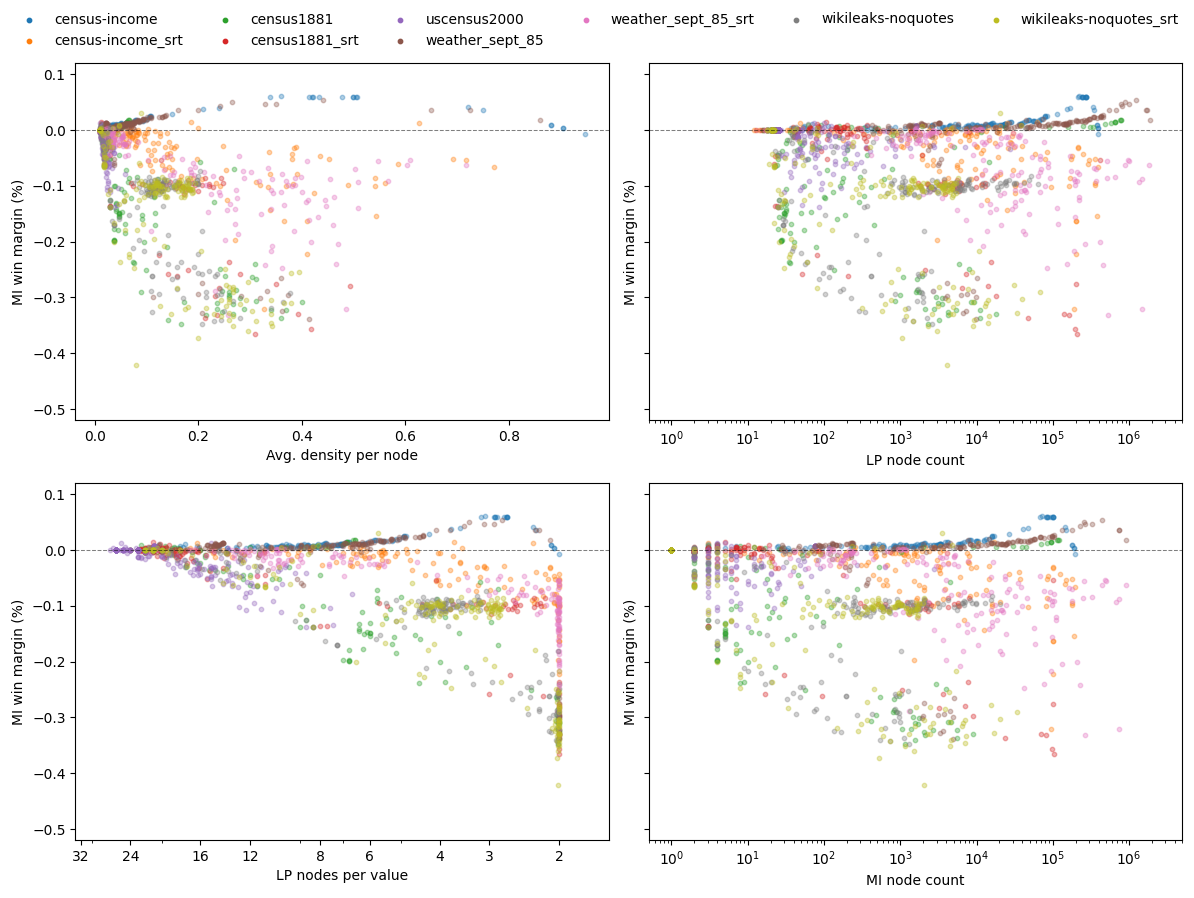

In [6]:
from matplotlib.ticker import FixedLocator, FuncFormatter

df2 = df_vs.copy()
df2["mi_win_margin"] = (df2["lp_bits"] - df2["mi_bits"]) / (df2["lp_bits"] + df2["mi_bits"])
df2["lp_nodes_per_value"] = df2["lp_nodes"] / df2["n"]
df2["dataset"] = df2["dataset"].astype("category")

ds_list = df2["dataset"].cat.categories.tolist()
color_map = {ds: matplotlib.colormaps["tab10"](i % 10) for i, ds in enumerate(ds_list)}

def scatter(ax, xcol, ycol="mi_win_margin", title=None, xlabel=None, ylabel=None):
    for ds in ds_list:
        mask = (df2["dataset"]==ds)
        ax.scatter(df2.loc[mask, xcol], df2.loc[mask, ycol], s=10, alpha=0.35, label=str(ds), color=color_map[ds])
    ax.axhline(0, color="k", linestyle="--", linewidth=0.75, alpha=0.5)
    ax.set_xlabel(xlabel or xcol)
    ax.set_ylabel(ylabel or ycol)
    ax.set_title(title)
    ax.set_ylim(-0.52, 0.12)

fig, axes = plt.subplots(2, 2, figsize=(12, 9), sharey=True)
scatter(axes[0, 0], "P{avg}.avg_density",  title="", xlabel="Avg. density per node", ylabel="MI win margin (%)")
scatter(axes[1, 0], "lp_nodes_per_value",  title="", xlabel="LP nodes per value", ylabel="MI win margin (%)")
axes[1, 0].set_xlim(33, 1.5)
axes[1, 0].set_xscale("log")
major_ticks = [2, 3, 4, 6, 8, 12, 16, 24, 32]
axes[1, 0].xaxis.set_major_locator(FixedLocator(major_ticks))
axes[1, 0].xaxis.set_major_formatter(FuncFormatter(lambda x, _: f"{int(x):,}" if x in major_ticks else ""))
scatter(axes[0, 1], "lp_nodes",  title="", xlabel="LP node count", ylabel="MI win margin (%)")
axes[0, 1].set_xscale("log")
axes[0, 1].set_xlim(0.5, 5e6)
scatter(axes[1, 1], "mi_nodes",  title="", xlabel="MI node count", ylabel="MI win margin (%)")
axes[1, 1].set_xscale("log")
axes[1, 1].set_xlim(0.5, 5e6)

handles, labels = axes[0, 0].get_legend_handles_labels()
leg = fig.legend(handles, labels, loc="upper center",
                 ncol=min(6, len(labels)), frameon=False)
for lh in leg.legend_handles:
    lh.set_alpha(1.0)

plt.tight_layout(rect=[0, 0, 1, 0.95]); plt.show()

# Failed Experiments: attempts to improve baseline compression

- Mixed BSP controller `bsp-mixed` (tagged policy switch) did not beat MI (≈+0.2%); the tag overhead erased wins.
- Cluster prepass `cluster-then-{LP,MI}` inflated bitsets by ~4–5.5% versus baselines.
- RLE prepass `rle-then-{LP,MI}` gave tiny wins only: ~0.7–1.1% better; not enough to justify the complexity.
- Early-stop leaf experiments for LP `leftpop-then-{enum,array}` had negligible effect, neither hurting or helping.

**Bottom line:** baseline LP/MI already sit near the practical Pareto frontier for size on these datasets. Further augmentations and/or tweaks are unlikely to yield meaningful improvement.

In [7]:
policies = [
  "leftpop",
  "median-index",           
  "bsp-mixed",
  "leftpop-then@N4-enum",
  "leftpop-then@N1-array",
  "cluster-then-leftpop",
  "cluster-then-median",
  "rle-then-leftpop",
  "rle-then-median"
]

megabit_table(df, policies)

Each column shows aggregate megabits across bitsets in a dataset:


,total,census-income,census-income_srt,census1881,census1881_srt,uscensus2000,weather_sept_85,weather_sept_85_srt,wikileaks-noquotes,wikileaks-noquotes_srt
policy,,,,,,,,,,
leftpop,40.653667,6.340121,1.101139,7.276686,0.664227,0.098404,21.732053,1.928701,1.167853,0.344483
median-index,39.591592,5.901386,1.157832,7.092708,0.754022,0.103411,20.630542,2.134984,1.407364,0.409343
bsp-mixed,39.669339,5.920177,1.141466,7.119171,0.745973,0.103516,20.841316,2.062702,1.345833,0.389186
leftpop-then@N4-enum,39.626634,6.006297,1.146502,7.044324,0.724703,0.104376,20.791903,2.062488,1.368631,0.377411
leftpop-then@N1-array,40.653667,6.340121,1.101139,7.276686,0.664227,0.098404,21.732053,1.928701,1.167853,0.344483
cluster-then-leftpop,42.274523,6.469301,1.148720,7.804695,0.728937,0.098610,22.376581,2.001541,1.270055,0.376081
cluster-then-median,41.764665,6.034257,1.247831,7.661394,0.857547,0.104184,21.351772,2.350401,1.677251,0.480027
rle-then-leftpop,40.352613,6.349606,1.050910,7.274812,0.638603,0.101636,21.740124,1.691981,1.166680,0.338261
rle-then-median,39.159334,5.913502,1.091093,7.085376,0.717694,0.106643,20.633057,1.814224,1.402392,0.395354


# Scalar Values: truncated binary codes

In BSP, each node emits a scalar $y\in[0,K)$ whose alphabet $K$ is rarely a power-of-two. Fixed codes using $\lceil \log_2 K\rceil$ bits per value are viable but leave compression on the table.

Let $b=\lfloor\log_2 K\rfloor$ and $t=2^{b+1}-K$ (count of short codewords). **Truncated binary (TB)** encodes:

* If $y<t$: emit $b$ bits for $y$.
* Else: emit $(b{+}1)$ bits for $y+t$.

**Decoding:** read $b$ bits $\to x$. If $x<t$, output $y=x$; otherwise read one deciding bit $d$ and output $y=(2x+d)-t$.

Empirically, TB shrinks our aggregate from **43.36→40.65 Mb** (~6.25%). An ideal uniform entropy code would reach **40.13 Mb**, so TB captures **~84%** of the possible gain.

Heavier entropy coding (e.g., ANS with an adaptive context model) could squeeze a few more points, but would add state/renormalization and serial dependencies, undermining random access, update locality, and SIMD parallelism. TB gets most of the benefit while staying simple.

In [8]:
policies = [
  "leftpop", # truncated binary
  "leftpop-scalar-fixed",
  "leftpop-scalar-uniform"
]

megabit_table(df, policies)

Each column shows aggregate megabits across bitsets in a dataset:


,total,census-income,census-income_srt,census1881,census1881_srt,uscensus2000,weather_sept_85,weather_sept_85_srt,wikileaks-noquotes,wikileaks-noquotes_srt
policy,,,,,,,,,,
leftpop,40.653667,6.340121,1.101139,7.276686,0.664227,0.098404,21.732053,1.928701,1.167853,0.344483
leftpop-scalar-fixed,43.364105,6.771880,1.181483,7.653083,0.718267,0.104347,23.207404,2.066508,1.286120,0.375013
leftpop-scalar-uniform,40.127742,6.256147,1.086071,7.200869,0.654529,0.097215,21.442205,1.903578,1.147727,0.339401


# Operational requirements for high-performance bitsets

For a compression scheme to be _operationally viable_ at high throughput, we need:

* **Short-circuitability.** Trivialise absorbing/neutral spans (all-zero/all-one) and surface cardinality/membership without full decode.
* **Slice locality.** Address and operate on ranges (e.g., `key in [L,R)`) with bounded work and good update locality.
* **Zipped traversal.** Tight `load chunk → operate → write` loops, streaming multiple inputs in lockstep and avoiding inflate-to-RAM.

Single-stage BSP (LP/MI) fails these requirements: subtree size is unknown until descent; random access touches many nodes; feasible alphabets depend on ancestor state. These don't preclude fast bulk operations, but significantly complicate implementation and limit operational flexibility.

## Solution Shape: two-stage layout

We split the universe by high (Stage-1) and low (Stage-2) bits:

- **Stage-1:** Performance-oriented map for non-empty spans (e.g., Judy16 over high 16 bits). Provides fast skip/copy for trivial cases and bounded access cost.
- **Stage-2:** Compression-oriented encoding for low bits (e.g., LP/MI, or simpler micro-containers). Blocks live in small, independent byte ranges and decode only for non-trivial work.

In aggregate, Stage-1 overhead is small: Judy16 indexing adds just 2.66 Mb (5.9% of total) when applied to low-8 LP-coded bits. The larger cost comes from metadata per Stage-2 root—recording cardinality alone requires 6.03 Mb (13.4% of total). Smaller Stage-2 block size covering low-$D$ bits improves throughput potential (at the cost of metadata overhead), while larger $D$ minimizes overhead (at the cost of operational flexibility).

In [9]:
policies = [
    "leftpop",
    "judy16-then@D16-leftpop",
    "judy16-then@D12-leftpop",
    "judy16-then@D8-leftpop",
    "median-index",
    "judy16-then@D16-median-index",
    "judy16-then@D12-median-index",
    "judy16-then@D8-median-index",
]

table = (
    df[df["policy"].isin(policies)]
    .assign(bsp_total=lambda d: d["R_bits"].where(d["R_bits"].ne(0), d["bits"]))
    .assign(bsp_n=lambda d: d["R_XFORM_bits"].where(d["R_XFORM_bits"].ne(0), d["XFORM_bits"]))
    .assign(bsp_body=lambda d: d["bsp_total"] - d["bsp_n"])
    .groupby("policy")[["bits", "L_bits", "bsp_n", "bsp_body"]]
    .sum().div(1e6).reindex(policies)
    .rename(columns={"bits": "Total (Mb)", "L_bits": "Judy (Mb)", "bsp_n": "BSP popcount (Mb)", "bsp_body": "BSP body (Mb)"})
    [["Total (Mb)", "Judy (Mb)", "BSP popcount (Mb)", "BSP body (Mb)"]]
)

table

,Total (Mb),Judy (Mb),BSP popcount (Mb),BSP body (Mb)
policy,,,,
leftpop,40.653667,0.000000,0.040297,40.613371
judy16-then@D16-leftpop,40.864664,0.145756,0.230960,40.487948
judy16-then@D12-leftpop,41.428305,0.458736,1.157460,39.812109
judy16-then@D8-leftpop,45.016372,2.659634,6.032584,36.324154
median-index,39.591592,0.000000,0.040297,39.551295
judy16-then@D16-median-index,39.907974,0.145756,0.230960,39.531258
judy16-then@D12-median-index,40.692802,0.458736,1.157460,39.076606
judy16-then@D8-median-index,44.406505,2.659634,6.032584,35.714287


## Performance potential

> **Speculative performance modeling. Not measured results.**

Assume a 3 GHz core with a 6 GB/s memory bus (~2 bytes/cycle round-trip). For "smaller → faster" scaling, our pipeline must process ≥16 bit positions/cycle to break-even with simple bitsets, and can then continue improving until 42 bit positions/cycle (LP's average efficiency: 12 bytes covers 256 positions).

Consider a two-input AND operation over low-8 bits (256-bit spans):

**Compute budget for break-even:**
- Simple bitsets: 2×32 bytes read + 32 bytes write = 96 bytes → 48 cycles
- Compressed bitsets: memory delivers data in 18 cycles, but we have 48 cycles total
- **Compute budget: 48 cycles** for 2× decode + operate + encode + overhead
- Allocation: ~15 cycles per decode, ~15 cycles for encode, ~3 cycles for load/store/operate (issue-only)

Even with instructions like bext/bdep 15 cycles per transcode is insufficient for our scheme's complexity level. The bitstream manipulation and control flow involved would substantially exceed this budget.

**Mitigating factors:**

Up to ~50% of work may be memory-bound (copy passthrough from Stage-1 triviality tests), effectively doubling the compute budget to ~30 cycles/transcode. For this to amortize effectively (assume 4096 byte store buffer), Stage-2 blocks should span ≲4096 bit positions: larger blocks would drain the buffer before completing. This favours $D∈\{8,12\}$ over $D=16$. Although even with a doubled compute budget, the margins remain tight given LP/MI transcode complexity.

**Takeaway:**

Beating simple bitset throughput with LP/MI through better memory bus utilization appears challenging. A well-optimized implementation might achieve:

- Comparable throughput to simple bitsets (break-even or similar)
- Superior performance for disk/network-bound workloads
- Significant memory footprint reduction (~46%)

This falls short of "smaller → proportionally faster" but may still provide value depending on the deployment context.

**Miscellaneous experiment: tags for full BSP blocks**

Instead of storing BSP root popcount for full blocks (all ones), it's possible to short-circuit with a 1-bit "full tag". This brings a small compression improvement, but the bigger advantage comes from accelerating triviality testing.

In [10]:
judy16_mb = df[df["policy"] == "judy16-then@D8-leftpop"]["bits"].sum() / 1e6
judyx_mb = df[df["policy"] == "judyX-then@D8-leftpop"]["bits"].sum() / 1e6

print(f"Using tags to skip full BSP blocks reduces the aggregate size by {(1 - judyx_mb / judy16_mb) * 100:.2f}% ({judy16_mb:.3f} → {judyx_mb:.3f} Mb)")

Using tags to skip full BSP blocks reduces the aggregate size by 1.18% (45.016 → 44.485 Mb)


# Performance Solution: Simpler Micro-Containers (PickBest)

If BSP decode complexity proves prohibitive for target throughput, simpler PickBest micro-containers over low-8 bits offer a pragmatic fallback:

1. Record popcount $p$ (1 byte)
2. Pick best storage based on $p$:
    - If $p < 32$, emit an array.
    - If $p > 224$, emit a co-array (holes).
    - Otherwise, emit a 256-bit bitmap.

Popcount gives reservation size, operations vectorize cleanly, streaming performance is predictable. With Judy16 for high bits this lands at 57.60 Mb, smaller than Roaring+RLE (by ~23.35%), and realising about half the compression improvement of single-stage LP.

In [11]:
policies = [
  "leftpop",
  "judy16-then@D8-pickbest",
  "roaring-B+A+R",
]


megabit_table(df, policies)

Each column shows aggregate megabits across bitsets in a dataset:


,total,census-income,census-income_srt,census1881,census1881_srt,uscensus2000,weather_sept_85,weather_sept_85_srt,wikileaks-noquotes,wikileaks-noquotes_srt
policy,,,,,,,,,,
leftpop,40.653667,6.340121,1.101139,7.276686,0.664227,0.098404,21.732053,1.928701,1.167853,0.344483
judy16-then@D8-pickbest,57.604058,7.193776,2.318824,9.612356,1.474004,0.205440,28.428889,5.161949,2.456146,0.752673
roaring-B+A+R,75.157776,9.467968,2.929712,15.077488,1.354400,0.166544,40.971648,3.401408,1.403936,0.384672


# Conclusion

BSP-inspired policies (LP/MI) establish a new compression baseline: **~46% smaller than Roaring+RLE** on standard benchmarks. However, performance modeling suggests the decode complexity may preclude throughput gains from reduced memory traffic—implementations will likely match (not exceed) simple bitset speeds.

## Recommended Architecture

The two-stage pattern remains promising:

**Stage 1 (high bits):** Performance-optimized indexing
* Example: Judy16 (16-ary radix tree over high 16 bits)
* Role: Fast skip/copy, bounded access cost, minimal overhead (~6%)

**Stage 2 (low 8-12 bits):** Compression-optimized encoding
* **Compression-first:** LP or MI (~46% smaller vs Roaring+RLE)
  * Requires complex decode; performance likely break-even at best
  * Best for memory-constrained or disk/network-bound workloads
* **Throughput-first:** Micro-containers like PickBest (~23% smaller vs Roaring+RLE)  
  * Simpler decode, predictable performance
  * Better bet for CPU-bound in-memory workloads

**Block size tradeoff:** D∈{8,12,16} balances metadata overhead (lower D = higher overhead) against operational flexibility (lower D = better locality, easier to amortize decode cost).

## What This Settles (and Doesn't)

**Settled:**
* BSP methods can compress bitsets substantially better than Roaring
* Two-stage designs maintain compression while enabling practical operations
* Judy16 + LP achieves ~46% improvement, Judy16 + PickBest achieves ~23%

**Open questions requiring implementation:**
* Can LP/MI decode be optimized to break-even throughput in practice?
* Do micro-containers like PickBest actually deliver their theoretical performance advantage?
* In real workloads, how often is data memory-bound vs CPU-bound?

The compression improvements are real and measured. Whether they translate to performance gains remains an implementation question—but the potential is credible enough to warrant the attempt.